# Лекция 3. Введение в bootstrap

## Содержание  
[3.1 Складной нож (jackknife)](#3.1)   
[3.2 Bootstrap](#3.2)  
[3.3 Практические задания](#3.3)  


## 3.1 Складной нож (jackknife)<a id="3.1"></a>

**Jackknife** - статистический метод ресэмплинга, используемый для оценки параметров моделей и их стандартных ошибок на основе исходных данных.  
Основной преимуществом метода jackknife является его простота в применении и широкая применимость к различным моделям и статистическим параметрам. Он позволяет получить оценку смещения и стандартной ошибки параметра, что может быть полезно для проверки статистической значимости оценок и понимания их достоверности.  
Метод имеет некоторые ограничения. В частности, он может быть чувствителен к выбросам и допущению о независимости наблюдений.  

**Алгоритм**:  
1) Из исходных данных удаляется одно наблюдение.  
2) Статистическая оценка рассчитывается на основе оставшихся данных.  
3) Шаги 1 и 2 повторяются для каждого наблюдения, поочередно исключая и возвращая его обратно.  
4) Совмещение оценок проводится путем вычисления среднего значения оценок и корректировки их на смещение.  

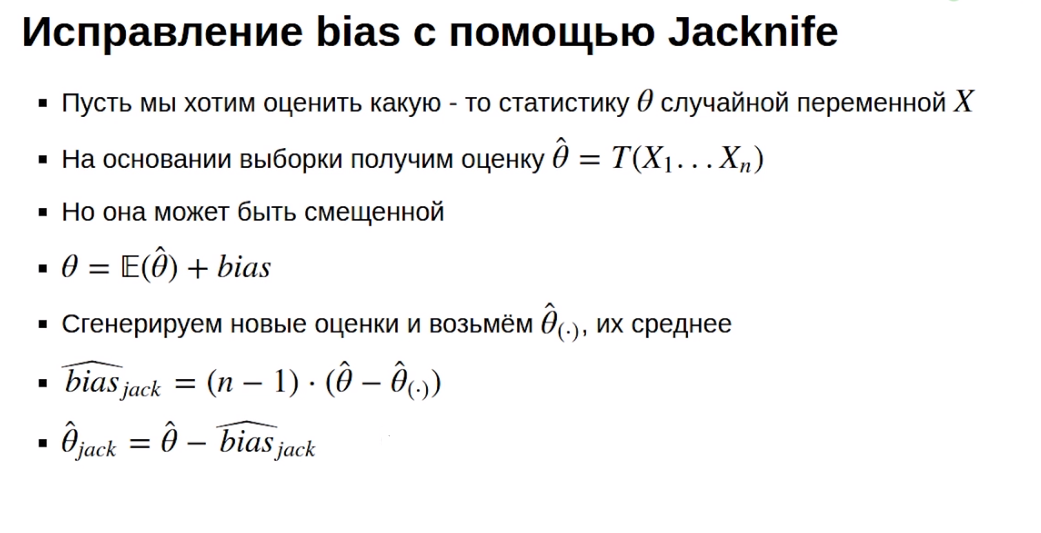

### Примеры:  

In [4]:
library(ggplot2)

In [1]:
# "Плохой" оценкщик дисперсии (со смещением)
bad_var_estimator <- function(x) {
  n <- length(x)
  return(var(x)*(n-1)/n)
}

# Коррекция смещения по методу Jackknife 
JN_bias_correction <- function(x, estimator) {

    n <- length(x)
    ind <- c(1:n)
    
    # заполняется вектор с оценками по выборкам, в которых выкинуто одно наблюдение
    theta_stars <- vector("numeric", n)
    
    for(i in ind) {
        sample <- x[ind != i]
        theta_stars[i] <- estimator(sample)
    }
  
    # оценка по полной выборке (смещенная оценка)
    theta_hat <- estimator(x)
    # средняя оценок по выборкам, с одним выкинутым наблюдением
    theta_dot <- mean(theta_stars)
  
    # смещенность
    bias_jack <- (theta_dot - theta_hat) * (n - 1)
    # оценка с учтенным смещением
    theta_hat_jack <- theta_hat - bias_jack
    
    return(theta_hat_jack)
}

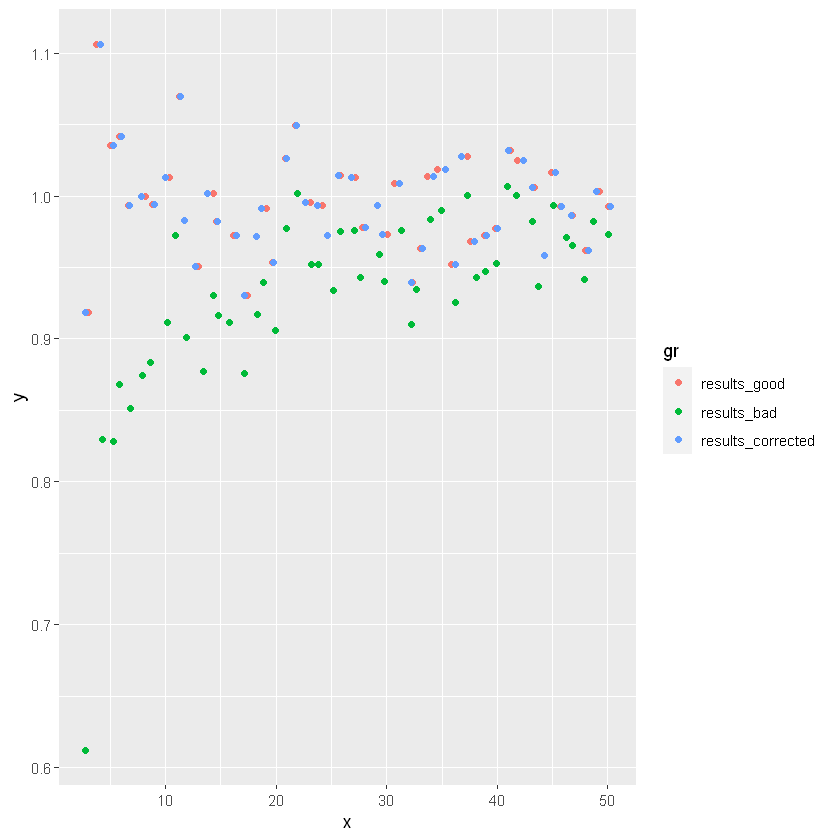

In [13]:
start <- 3

sample_sizes <- c(start:50)
test <- 100

# Встроенная - правильная оценка дисперсии
results_good <- sample_sizes
# Оценка дисперсии с bad_var_estimator
results_bad <- sample_sizes
# Оценка дисперсии исправленным методом с JN_bias_correction
results_corrected <- sample_sizes

for (n in sample_sizes){
    samples <- matrix(rnorm(n*test), n)
  
    good_estimations <- apply(samples, 2, var)
    bad_estimations <- apply(samples, 2, bad_var_estimator)
    corrected_estimations <- apply(samples, 2, JN_bias_correction, estimator = bad_var_estimator)
  
    results_good[n-start+1] <- mean(good_estimations)
    results_bad[n-start+1] <- mean(bad_estimations)
    results_corrected[n-start+1] <- mean(corrected_estimations)
}

df <- data.frame(x = rep(sample_sizes,3),
                 y = c(results_good,results_bad, results_corrected),
                 gr = factor(rep(1:3, each = length(sample_sizes)),
                 labels = c("results_good", "results_bad", "results_corrected")))

ggplot(df, aes(x, y, col = gr)) + geom_jitter()

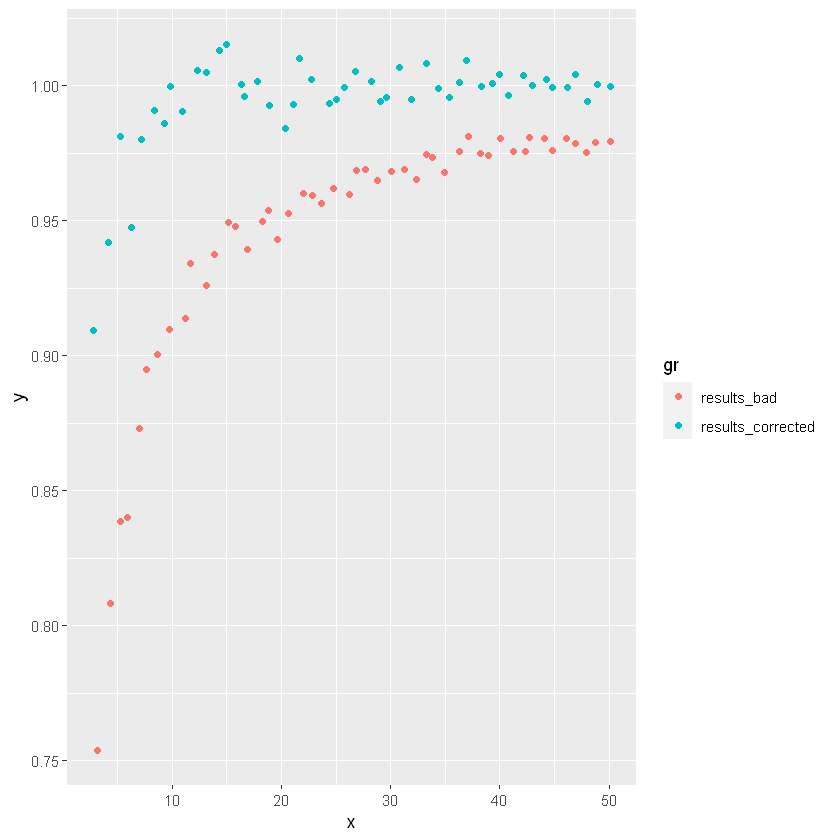

In [14]:
# Оценка максимального значения ГС по выборке
start <- 3

sample_sizes <- c(start:50)
test <- 100

# Оценка дисперсии с bad_var_estimator
results_bad <- sample_sizes
# Оценка дисперсии исправленным методом с JN_bias_correction
results_corrected <- sample_sizes

for (n in sample_sizes){
    samples <- matrix(runif(n*test, min = 0, max = 1), n)
  
    bad_estimations <- apply(samples, 2, max)
    corrected_estimations <- apply(samples, 2, JN_bias_correction, estimator = max)
  
    results_bad[n-start+1] <- mean(bad_estimations)
    results_corrected[n-start+1] <- mean(corrected_estimations)
}

df <- data.frame(x = rep(sample_sizes,2),
                 y = c(results_bad, results_corrected),
                 gr = factor(rep(1:2, each = length(sample_sizes)),
                 labels = c("results_bad", "results_corrected")))

ggplot(df, aes(x, y, col = gr)) + geom_jitter()

## 3.2 Bootstrap<a id="3.2"></a>

**Bootstrap** -  метод ресемплинга данных, который позволяет получить надежную оценку параметров или доверительные интервалы путем симуляции повторных выборок из исходного набора данных.  

**Идея bootstrap** заключается в том, чтобы извлечь рандомные выборки из исходной выборки с возвращением. Это значит, что каждый элемент исходной выборки может быть выбран множество раз, а некоторые элементы могут не быть выбраны вовсе. При таком подходе размер выборки-реплики будет таким же, как размер исходной выборки.  

**Алгоритм**:  
1) Взять случайную выборку из исходных данных.  
2) Оценить интересующий параметр по этой выборке.  
3) Повторить эти шаги множество раз (например, 1000 раз).  
4) Сформировать распределение оценок параметра и получить доверительный интервал.  

Bootstrap позволяет оценить точность оценок параметров, основываясь на распределении, полученном из всего набора повторных выборок. Он также позволяет решить проблему с неопределенностью выбора выборки, которая может возникнуть, когда исходные данные ограничены.  